In [11]:
import numpy as np
import pandas as pd
import os
import torch
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import dgl
import sklearn
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [25]:
# df_gemaps=gemaps
# df_gemaps['filename']=fname
df=pd.read_csv('./mfcc/features_3_sec.csv')
# df=df_gemaps.merge(df,on='filename')


# cnn=pd.read_csv("CNN_featrues.csv")
# df=pd.concat([cnn,df],axis=1)
df=df.drop(labels="filename",axis=1)
df=df[(df.label=='blues')|(df.label=='jazz')]
# df=df[['rms_var', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'mfcc5_var', 'mfcc6_mean', 'mfcc7_var', 'mfcc10_var', 'mfcc17_mean', 'mfcc20_var','label']]
df=df.sample(n=2000)
df.label.value_counts()
X=StandardScaler().fit_transform(np.array(df.iloc[:,:-1],dtype=float))
class_list=df.iloc[:,-1]
converter=LabelEncoder()
y=converter.fit_transform(class_list)
print(X.shape,y.shape)
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)
# print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

X_train=X[0:1340,:]
y_train=y[0:1340]
X_test=X[1340:,:]
y_test=y[1340:]

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

mfccs_total=X
labels_total=y
labels_train=y_train
labels_test=y_test

kpca_mfccs_total=mfccs_total

(2000, 58) (2000,)
(1340, 58) (660, 58) (1340,) (660,)


In [26]:
from sklearn.neighbors import NearestNeighbors
num_neigh = 800
neigh1 = NearestNeighbors(n_neighbors=num_neigh, radius=1,metric='jaccard')
neigh1.fit(kpca_mfccs_total)

adj_matrix_total = np.zeros((len(labels_total),len(labels_total)))

for i in tqdm(range(len(labels_total))):
#     if i==1:
    
        dist1, nbors1 =neigh1.kneighbors([kpca_mfccs_total[i,:]])

        #only keep train neighbor
        nbors1 = nbors1[nbors1<len(labels_train)]
        
        neigh_total = np.array(nbors1).squeeze().flatten()
#         print(neigh_total)
        neigh_total = np.unique(neigh_total)
#         print(neigh_total)
        adj_matrix_total[i,neigh_total] = 1
        adj_matrix_total[neigh_total,i] = 1

        
adj_matrix_total = np.zeros((len(labels_total),len(labels_total)))

for i in tqdm(range(len(labels_total))):

    dist1, nbors1 =neigh1.kneighbors([kpca_mfccs_total[i,:]])
    #only keep train neighbor
    dist1 = dist1[nbors1<len(labels_train)]
    nbors1 = nbors1[nbors1<len(labels_train)]

    n_total = []
    n_total.append(nbors1)

    dist_total = []
    dist_total.append(dist1)

    neigh_total = np.array(n_total).squeeze().flatten()
    dist_total = np.array(dist_total).squeeze().flatten()

    neigh_total = np.unique(neigh_total)

    for j in range(len(neigh_total)):
        adj_matrix_total[i,neigh_total[j]] = dist_total[j]
        adj_matrix_total[neigh_total[j],i] = dist_total[j]
        
#train graph
nx_graph_train = nx.from_numpy_matrix(adj_matrix_total[0:len(labels_train),0:len(labels_train)])
g_dgl_euclid_train = dgl.from_networkx(nx_graph_train)
g_dgl_euclid_train

#test graph
nx_graph_test = nx.from_numpy_matrix(adj_matrix_total[len(labels_train):,len(labels_train):])
g_dgl_euclid_test = dgl.from_networkx(nx_graph_test)
g_dgl_euclid_test

#Total Graph
nx_graph_total= nx.from_numpy_matrix(adj_matrix_total)
g_dgl_euclid_total = dgl.from_networkx(nx_graph_total)
g_dgl_euclid_total

100%|██████████| 2000/2000 [00:02<00:00, 851.41it/s]


Graph(num_nodes=2000, num_edges=0,
      ndata_schemes={}
      edata_schemes={})

In [27]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

gcn_reduce

def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
def metrics_summary(val, pred):
    sens = recall_score(val, pred)
    spec = recall_score(1-val, 1-pred)
    prec = precision_score(val, pred)
    harmonic = 2*spec*sens/(sens+spec)

    print("prec: ", prec)
    print("sens: ", sens)
    print("spec: ", spec)
    print("harmonic: ", harmonic)
    
###create train and valid
train_len = len(labels_train)
train_mask_full = np.full(len(labels_total),True)
train_mask_full[train_len:]= False
valid_mask_full = ~train_mask_full
t_mask = th.BoolTensor(train_mask_full)
v_mask = th.BoolTensor(valid_mask_full)
inputs_g_total = torch.tensor(kpca_mfccs_total).float()
labels_graph = torch.tensor(labels_total).long()

###create train and valid

train_mask = np.full(len(labels_train),True)
t_mask2 = th.BoolTensor(train_mask)

test_mask = np.full(len(labels_test),True)
t_mask_test = th.BoolTensor(test_mask)


inputs_g_train = torch.tensor(kpca_mfccs_total[:len(labels_train)]).float()
labels_graph_train = torch.tensor(labels_train).long()

inputs_g_test = torch.tensor(kpca_mfccs_total[len(labels_train):]).float()
labels_graph_test = torch.tensor(labels_test).long()


train_mask_total = np.full(len(labels_total),True)
t_mask_total = th.BoolTensor(train_mask_total)





In [30]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean',feat_drop=0.05)
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=hid_feats, aggregator_type='mean',feat_drop=0.05)
#         self.conv4 = dglnn.SAGEConv(
#             in_feats=hid_feats, out_feats=hid_feats, aggregator_type='mean',feat_drop=0.01)
        self.conv3 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        h = F.relu(h)
        
        
#         h = self.conv2(graph, h)
#         h = F.relu(h)
#         h = self.conv2(graph, h)
#         h = F.relu(h)
#         h = self.conv2(graph, h)
#         h = F.relu(h)
#         h = self.conv2(graph, h)
#         h = F.relu(h)
        
#         h = self.conv4(graph, h)
#         h = F.relu(h)
#         h = self.conv4(graph, h)
#         h = F.relu(h)
#         h = self.conv4(graph, h)
#         h = F.relu(h)
#         h = self.conv4(graph, h)
#         h = F.relu(h)
        
        h = self.conv3(graph, h)
        
        return h
    
model_gsage = SAGE(in_feats=58, hid_feats=80, out_feats=2)
opt = th.optim.Adam(model_gsage.parameters(),lr=0.001)
model_gsage.train()
loss_list=[]
acc_list=[]
acc_test_list=[]
for epoch in range(200):
    out = model_gsage(g_dgl_euclid_train, inputs_g_train)
    # compute loss
    loss = F.cross_entropy(out, labels_graph_train)
    # compute validation accuracy
    acc = evaluate(model_gsage, g_dgl_euclid_train, inputs_g_train, labels_graph_train, t_mask2)
    acc_test=evaluate(model_gsage, g_dgl_euclid_test, inputs_g_test, labels_graph_test, t_mask_test)
    loss_list.append(loss.detach().numpy())
    acc_list.append(acc)
    acc_test_list.append(acc_test)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print("Epoch {:05d} | Loss {:.4f} | Train Acc {:.4f}| Test Acc {:.4f}".format(
            epoch, loss.item(), acc,acc_test))

Epoch 00000 | Loss 1.0138 | Train Acc 0.5604| Test Acc 0.5424
Epoch 00001 | Loss 0.8174 | Train Acc 0.5903| Test Acc 0.5606
Epoch 00002 | Loss 0.7200 | Train Acc 0.6246| Test Acc 0.6045
Epoch 00003 | Loss 0.6496 | Train Acc 0.6396| Test Acc 0.6439
Epoch 00004 | Loss 0.5974 | Train Acc 0.6649| Test Acc 0.6864
Epoch 00005 | Loss 0.5558 | Train Acc 0.7112| Test Acc 0.7227
Epoch 00006 | Loss 0.5189 | Train Acc 0.7515| Test Acc 0.7621
Epoch 00007 | Loss 0.4839 | Train Acc 0.7828| Test Acc 0.7864
Epoch 00008 | Loss 0.4501 | Train Acc 0.8067| Test Acc 0.7985
Epoch 00009 | Loss 0.4177 | Train Acc 0.8284| Test Acc 0.8152
Epoch 00010 | Loss 0.3880 | Train Acc 0.8381| Test Acc 0.8318
Epoch 00011 | Loss 0.3615 | Train Acc 0.8448| Test Acc 0.8515
Epoch 00012 | Loss 0.3386 | Train Acc 0.8672| Test Acc 0.8576
Epoch 00013 | Loss 0.3192 | Train Acc 0.8731| Test Acc 0.8742
Epoch 00014 | Loss 0.3027 | Train Acc 0.8821| Test Acc 0.8788
Epoch 00015 | Loss 0.2884 | Train Acc 0.8888| Test Acc 0.8909
Epoch 00

Epoch 00137 | Loss 0.0180 | Train Acc 0.9993| Test Acc 0.9652
Epoch 00138 | Loss 0.0177 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00139 | Loss 0.0174 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00140 | Loss 0.0171 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00141 | Loss 0.0169 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00142 | Loss 0.0166 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00143 | Loss 0.0163 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00144 | Loss 0.0161 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00145 | Loss 0.0158 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00146 | Loss 0.0155 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00147 | Loss 0.0153 | Train Acc 1.0000| Test Acc 0.9667
Epoch 00148 | Loss 0.0151 | Train Acc 1.0000| Test Acc 0.9667
Epoch 00149 | Loss 0.0148 | Train Acc 1.0000| Test Acc 0.9667
Epoch 00150 | Loss 0.0146 | Train Acc 1.0000| Test Acc 0.9667
Epoch 00151 | Loss 0.0144 | Train Acc 1.0000| Test Acc 0.9667
Epoch 00152 | Loss 0.0141 | Train Acc 1.0000| Test Acc 0.9667
Epoch 00

Text(0, 0.5, 'Accuracy')

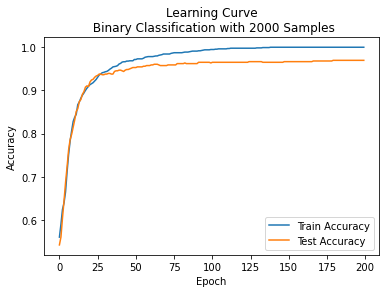

In [36]:
plt.plot(acc_list,label='Train Accuracy')
# plt.plot(loss_list,label='Loss')
plt.plot(acc_test_list,label='Test Accuracy')
plt.legend()
plt.title('Learning Curve\n Binary Classification with 2000 Samples')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [38]:
acc_list=[]
acc_test_list=[]
sens=[]
spec=[]
dice=[]
prec=[]
for i in range(10):
    model_gsage = SAGE(in_feats=58, hid_feats=80, out_feats=2)
    opt = th.optim.Adam(model_gsage.parameters(),lr=0.001)
    model_gsage.train()
    for epoch in range(200):
        out = model_gsage(g_dgl_euclid_train, inputs_g_train)
        # compute loss
        loss = F.cross_entropy(out, labels_graph_train)
        # compute validation accuracy
        acc = evaluate(model_gsage, g_dgl_euclid_train, inputs_g_train, labels_graph_train, t_mask2)
        acc_test=evaluate(model_gsage, g_dgl_euclid_test, inputs_g_test, labels_graph_test, t_mask_test)
        opt.zero_grad()
        loss.backward()
        opt.step()
        print("Epoch {:05d} | Loss {:.4f} | Train Acc {:.4f}| Test Acc {:.4f}".format(
                epoch, loss.item(), acc,acc_test))
    acc_list.append(evaluate(model_gsage, g_dgl_euclid_train, inputs_g_train, labels_graph_train, t_mask2))
    acc_test_list.append( evaluate(model_gsage, g_dgl_euclid_test, inputs_g_test, labels_graph_test, t_mask_test))
#     out = model_gsage(g_dgl_euclid_test, inputs_g_test)
#     prob=torch.softmax(out[t_mask_test],1).cpu().detach().numpy()
#     prob=pd.DataFrame(prob,columns=['prob_blues','prob_rock'])
#     y_pred=prob.prob_blues.apply(lambda x: 0 if x>0.5 else 1)
    
#     sens.append( recall_score(y_test, y_pred))
#     spec.append(recall_score(1-y_test, 1-y_pred))
#     dice.append(2*spec*sens/(spec+sens))
#     prec.append(precision_score(y_test, y_pred))


Epoch 00000 | Loss 1.4874 | Train Acc 0.3463| Test Acc 0.3788
Epoch 00001 | Loss 1.2173 | Train Acc 0.3701| Test Acc 0.4242
Epoch 00002 | Loss 1.0374 | Train Acc 0.4157| Test Acc 0.4576
Epoch 00003 | Loss 0.8910 | Train Acc 0.4806| Test Acc 0.5061
Epoch 00004 | Loss 0.7754 | Train Acc 0.5381| Test Acc 0.5788
Epoch 00005 | Loss 0.6842 | Train Acc 0.6045| Test Acc 0.6500
Epoch 00006 | Loss 0.6113 | Train Acc 0.6761| Test Acc 0.7121
Epoch 00007 | Loss 0.5516 | Train Acc 0.7149| Test Acc 0.7621
Epoch 00008 | Loss 0.5020 | Train Acc 0.7590| Test Acc 0.7924
Epoch 00009 | Loss 0.4608 | Train Acc 0.7851| Test Acc 0.8167
Epoch 00010 | Loss 0.4264 | Train Acc 0.8119| Test Acc 0.8333
Epoch 00011 | Loss 0.3980 | Train Acc 0.8231| Test Acc 0.8530
Epoch 00012 | Loss 0.3746 | Train Acc 0.8448| Test Acc 0.8652
Epoch 00013 | Loss 0.3552 | Train Acc 0.8560| Test Acc 0.8742
Epoch 00014 | Loss 0.3388 | Train Acc 0.8642| Test Acc 0.8773
Epoch 00015 | Loss 0.3247 | Train Acc 0.8679| Test Acc 0.8864
Epoch 00

Epoch 00134 | Loss 0.0296 | Train Acc 0.9955| Test Acc 0.9667
Epoch 00135 | Loss 0.0291 | Train Acc 0.9955| Test Acc 0.9667
Epoch 00136 | Loss 0.0286 | Train Acc 0.9955| Test Acc 0.9667
Epoch 00137 | Loss 0.0282 | Train Acc 0.9955| Test Acc 0.9667
Epoch 00138 | Loss 0.0277 | Train Acc 0.9955| Test Acc 0.9667
Epoch 00139 | Loss 0.0272 | Train Acc 0.9955| Test Acc 0.9667
Epoch 00140 | Loss 0.0268 | Train Acc 0.9963| Test Acc 0.9667
Epoch 00141 | Loss 0.0264 | Train Acc 0.9963| Test Acc 0.9667
Epoch 00142 | Loss 0.0259 | Train Acc 0.9963| Test Acc 0.9682
Epoch 00143 | Loss 0.0255 | Train Acc 0.9963| Test Acc 0.9682
Epoch 00144 | Loss 0.0251 | Train Acc 0.9963| Test Acc 0.9682
Epoch 00145 | Loss 0.0247 | Train Acc 0.9970| Test Acc 0.9682
Epoch 00146 | Loss 0.0243 | Train Acc 0.9970| Test Acc 0.9682
Epoch 00147 | Loss 0.0239 | Train Acc 0.9985| Test Acc 0.9682
Epoch 00148 | Loss 0.0235 | Train Acc 0.9985| Test Acc 0.9682
Epoch 00149 | Loss 0.0231 | Train Acc 0.9985| Test Acc 0.9682
Epoch 00

Epoch 00068 | Loss 0.0765 | Train Acc 0.9776| Test Acc 0.9333
Epoch 00069 | Loss 0.0751 | Train Acc 0.9784| Test Acc 0.9333
Epoch 00070 | Loss 0.0736 | Train Acc 0.9791| Test Acc 0.9333
Epoch 00071 | Loss 0.0722 | Train Acc 0.9799| Test Acc 0.9348
Epoch 00072 | Loss 0.0709 | Train Acc 0.9806| Test Acc 0.9364
Epoch 00073 | Loss 0.0695 | Train Acc 0.9806| Test Acc 0.9364
Epoch 00074 | Loss 0.0682 | Train Acc 0.9813| Test Acc 0.9364
Epoch 00075 | Loss 0.0669 | Train Acc 0.9813| Test Acc 0.9394
Epoch 00076 | Loss 0.0656 | Train Acc 0.9836| Test Acc 0.9409
Epoch 00077 | Loss 0.0644 | Train Acc 0.9836| Test Acc 0.9409
Epoch 00078 | Loss 0.0632 | Train Acc 0.9843| Test Acc 0.9409
Epoch 00079 | Loss 0.0620 | Train Acc 0.9843| Test Acc 0.9409
Epoch 00080 | Loss 0.0608 | Train Acc 0.9843| Test Acc 0.9424
Epoch 00081 | Loss 0.0597 | Train Acc 0.9843| Test Acc 0.9424
Epoch 00082 | Loss 0.0586 | Train Acc 0.9843| Test Acc 0.9439
Epoch 00083 | Loss 0.0575 | Train Acc 0.9843| Test Acc 0.9439
Epoch 00

Epoch 00009 | Loss 0.4004 | Train Acc 0.8388| Test Acc 0.8197
Epoch 00010 | Loss 0.3705 | Train Acc 0.8552| Test Acc 0.8333
Epoch 00011 | Loss 0.3449 | Train Acc 0.8664| Test Acc 0.8500
Epoch 00012 | Loss 0.3226 | Train Acc 0.8724| Test Acc 0.8576
Epoch 00013 | Loss 0.3031 | Train Acc 0.8828| Test Acc 0.8712
Epoch 00014 | Loss 0.2858 | Train Acc 0.8881| Test Acc 0.8773
Epoch 00015 | Loss 0.2705 | Train Acc 0.8970| Test Acc 0.8864
Epoch 00016 | Loss 0.2568 | Train Acc 0.9045| Test Acc 0.8970
Epoch 00017 | Loss 0.2447 | Train Acc 0.9097| Test Acc 0.8985
Epoch 00018 | Loss 0.2338 | Train Acc 0.9157| Test Acc 0.9045
Epoch 00019 | Loss 0.2241 | Train Acc 0.9187| Test Acc 0.9091
Epoch 00020 | Loss 0.2152 | Train Acc 0.9239| Test Acc 0.9106
Epoch 00021 | Loss 0.2071 | Train Acc 0.9261| Test Acc 0.9152
Epoch 00022 | Loss 0.1997 | Train Acc 0.9306| Test Acc 0.9182
Epoch 00023 | Loss 0.1928 | Train Acc 0.9306| Test Acc 0.9227
Epoch 00024 | Loss 0.1863 | Train Acc 0.9336| Test Acc 0.9273
Epoch 00

Epoch 00144 | Loss 0.0155 | Train Acc 0.9993| Test Acc 0.9682
Epoch 00145 | Loss 0.0152 | Train Acc 0.9993| Test Acc 0.9682
Epoch 00146 | Loss 0.0149 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00147 | Loss 0.0146 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00148 | Loss 0.0143 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00149 | Loss 0.0141 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00150 | Loss 0.0138 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00151 | Loss 0.0136 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00152 | Loss 0.0133 | Train Acc 1.0000| Test Acc 0.9697
Epoch 00153 | Loss 0.0131 | Train Acc 1.0000| Test Acc 0.9697
Epoch 00154 | Loss 0.0128 | Train Acc 1.0000| Test Acc 0.9697
Epoch 00155 | Loss 0.0126 | Train Acc 1.0000| Test Acc 0.9697
Epoch 00156 | Loss 0.0124 | Train Acc 1.0000| Test Acc 0.9697
Epoch 00157 | Loss 0.0121 | Train Acc 1.0000| Test Acc 0.9697
Epoch 00158 | Loss 0.0119 | Train Acc 1.0000| Test Acc 0.9697
Epoch 00159 | Loss 0.0117 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00

Epoch 00079 | Loss 0.0352 | Train Acc 0.9963| Test Acc 0.9545
Epoch 00080 | Loss 0.0343 | Train Acc 0.9963| Test Acc 0.9545
Epoch 00081 | Loss 0.0334 | Train Acc 0.9963| Test Acc 0.9545
Epoch 00082 | Loss 0.0325 | Train Acc 0.9963| Test Acc 0.9530
Epoch 00083 | Loss 0.0317 | Train Acc 0.9963| Test Acc 0.9530
Epoch 00084 | Loss 0.0309 | Train Acc 0.9963| Test Acc 0.9530
Epoch 00085 | Loss 0.0301 | Train Acc 0.9963| Test Acc 0.9530
Epoch 00086 | Loss 0.0293 | Train Acc 0.9963| Test Acc 0.9530
Epoch 00087 | Loss 0.0286 | Train Acc 0.9963| Test Acc 0.9545
Epoch 00088 | Loss 0.0279 | Train Acc 0.9963| Test Acc 0.9561
Epoch 00089 | Loss 0.0271 | Train Acc 0.9963| Test Acc 0.9561
Epoch 00090 | Loss 0.0265 | Train Acc 0.9963| Test Acc 0.9561
Epoch 00091 | Loss 0.0258 | Train Acc 0.9963| Test Acc 0.9576
Epoch 00092 | Loss 0.0252 | Train Acc 0.9963| Test Acc 0.9576
Epoch 00093 | Loss 0.0245 | Train Acc 0.9963| Test Acc 0.9576
Epoch 00094 | Loss 0.0239 | Train Acc 0.9963| Test Acc 0.9576
Epoch 00

Epoch 00012 | Loss 0.2956 | Train Acc 0.8836| Test Acc 0.8682
Epoch 00013 | Loss 0.2799 | Train Acc 0.8896| Test Acc 0.8758
Epoch 00014 | Loss 0.2657 | Train Acc 0.8955| Test Acc 0.8833
Epoch 00015 | Loss 0.2529 | Train Acc 0.8993| Test Acc 0.8848
Epoch 00016 | Loss 0.2414 | Train Acc 0.9022| Test Acc 0.8864
Epoch 00017 | Loss 0.2311 | Train Acc 0.9104| Test Acc 0.8879
Epoch 00018 | Loss 0.2218 | Train Acc 0.9142| Test Acc 0.8939
Epoch 00019 | Loss 0.2133 | Train Acc 0.9172| Test Acc 0.8939
Epoch 00020 | Loss 0.2057 | Train Acc 0.9201| Test Acc 0.8924
Epoch 00021 | Loss 0.1988 | Train Acc 0.9254| Test Acc 0.8955
Epoch 00022 | Loss 0.1926 | Train Acc 0.9284| Test Acc 0.8939
Epoch 00023 | Loss 0.1869 | Train Acc 0.9291| Test Acc 0.8970
Epoch 00024 | Loss 0.1817 | Train Acc 0.9336| Test Acc 0.9030
Epoch 00025 | Loss 0.1769 | Train Acc 0.9351| Test Acc 0.9015
Epoch 00026 | Loss 0.1723 | Train Acc 0.9373| Test Acc 0.9045
Epoch 00027 | Loss 0.1680 | Train Acc 0.9403| Test Acc 0.9061
Epoch 00

Epoch 00151 | Loss 0.0170 | Train Acc 0.9993| Test Acc 0.9591
Epoch 00152 | Loss 0.0167 | Train Acc 0.9993| Test Acc 0.9591
Epoch 00153 | Loss 0.0164 | Train Acc 0.9993| Test Acc 0.9606
Epoch 00154 | Loss 0.0161 | Train Acc 0.9993| Test Acc 0.9621
Epoch 00155 | Loss 0.0158 | Train Acc 0.9993| Test Acc 0.9621
Epoch 00156 | Loss 0.0155 | Train Acc 0.9993| Test Acc 0.9621
Epoch 00157 | Loss 0.0152 | Train Acc 0.9993| Test Acc 0.9621
Epoch 00158 | Loss 0.0150 | Train Acc 1.0000| Test Acc 0.9621
Epoch 00159 | Loss 0.0147 | Train Acc 1.0000| Test Acc 0.9606
Epoch 00160 | Loss 0.0144 | Train Acc 1.0000| Test Acc 0.9606
Epoch 00161 | Loss 0.0142 | Train Acc 1.0000| Test Acc 0.9621
Epoch 00162 | Loss 0.0139 | Train Acc 1.0000| Test Acc 0.9621
Epoch 00163 | Loss 0.0137 | Train Acc 1.0000| Test Acc 0.9621
Epoch 00164 | Loss 0.0134 | Train Acc 1.0000| Test Acc 0.9621
Epoch 00165 | Loss 0.0132 | Train Acc 1.0000| Test Acc 0.9621
Epoch 00166 | Loss 0.0130 | Train Acc 1.0000| Test Acc 0.9621
Epoch 00

Epoch 00088 | Loss 0.0291 | Train Acc 0.9963| Test Acc 0.9682
Epoch 00089 | Loss 0.0284 | Train Acc 0.9963| Test Acc 0.9682
Epoch 00090 | Loss 0.0277 | Train Acc 0.9963| Test Acc 0.9697
Epoch 00091 | Loss 0.0270 | Train Acc 0.9970| Test Acc 0.9697
Epoch 00092 | Loss 0.0263 | Train Acc 0.9970| Test Acc 0.9697
Epoch 00093 | Loss 0.0257 | Train Acc 0.9970| Test Acc 0.9697
Epoch 00094 | Loss 0.0250 | Train Acc 0.9970| Test Acc 0.9697
Epoch 00095 | Loss 0.0244 | Train Acc 0.9970| Test Acc 0.9697
Epoch 00096 | Loss 0.0238 | Train Acc 0.9970| Test Acc 0.9697
Epoch 00097 | Loss 0.0232 | Train Acc 0.9970| Test Acc 0.9697
Epoch 00098 | Loss 0.0227 | Train Acc 0.9970| Test Acc 0.9697
Epoch 00099 | Loss 0.0221 | Train Acc 0.9970| Test Acc 0.9712
Epoch 00100 | Loss 0.0216 | Train Acc 0.9978| Test Acc 0.9712
Epoch 00101 | Loss 0.0211 | Train Acc 0.9978| Test Acc 0.9712
Epoch 00102 | Loss 0.0206 | Train Acc 0.9978| Test Acc 0.9712
Epoch 00103 | Loss 0.0201 | Train Acc 0.9978| Test Acc 0.9727
Epoch 00

Epoch 00029 | Loss 0.1650 | Train Acc 0.9440| Test Acc 0.9394
Epoch 00030 | Loss 0.1606 | Train Acc 0.9455| Test Acc 0.9409
Epoch 00031 | Loss 0.1562 | Train Acc 0.9485| Test Acc 0.9409
Epoch 00032 | Loss 0.1521 | Train Acc 0.9530| Test Acc 0.9409
Epoch 00033 | Loss 0.1481 | Train Acc 0.9545| Test Acc 0.9439
Epoch 00034 | Loss 0.1443 | Train Acc 0.9560| Test Acc 0.9439
Epoch 00035 | Loss 0.1406 | Train Acc 0.9560| Test Acc 0.9439
Epoch 00036 | Loss 0.1372 | Train Acc 0.9575| Test Acc 0.9439
Epoch 00037 | Loss 0.1339 | Train Acc 0.9582| Test Acc 0.9455
Epoch 00038 | Loss 0.1308 | Train Acc 0.9604| Test Acc 0.9409
Epoch 00039 | Loss 0.1278 | Train Acc 0.9604| Test Acc 0.9409
Epoch 00040 | Loss 0.1249 | Train Acc 0.9612| Test Acc 0.9424
Epoch 00041 | Loss 0.1221 | Train Acc 0.9619| Test Acc 0.9424
Epoch 00042 | Loss 0.1194 | Train Acc 0.9634| Test Acc 0.9439
Epoch 00043 | Loss 0.1168 | Train Acc 0.9649| Test Acc 0.9439
Epoch 00044 | Loss 0.1142 | Train Acc 0.9657| Test Acc 0.9439
Epoch 00

Epoch 00165 | Loss 0.0099 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00166 | Loss 0.0098 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00167 | Loss 0.0096 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00168 | Loss 0.0094 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00169 | Loss 0.0093 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00170 | Loss 0.0091 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00171 | Loss 0.0090 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00172 | Loss 0.0089 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00173 | Loss 0.0087 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00174 | Loss 0.0086 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00175 | Loss 0.0085 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00176 | Loss 0.0083 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00177 | Loss 0.0082 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00178 | Loss 0.0081 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00179 | Loss 0.0080 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00180 | Loss 0.0078 | Train Acc 1.0000| Test Acc 0.9712
Epoch 00

Epoch 00101 | Loss 0.0314 | Train Acc 0.9955| Test Acc 0.9621
Epoch 00102 | Loss 0.0307 | Train Acc 0.9955| Test Acc 0.9621
Epoch 00103 | Loss 0.0300 | Train Acc 0.9955| Test Acc 0.9621
Epoch 00104 | Loss 0.0293 | Train Acc 0.9955| Test Acc 0.9652
Epoch 00105 | Loss 0.0287 | Train Acc 0.9955| Test Acc 0.9652
Epoch 00106 | Loss 0.0280 | Train Acc 0.9955| Test Acc 0.9652
Epoch 00107 | Loss 0.0274 | Train Acc 0.9955| Test Acc 0.9652
Epoch 00108 | Loss 0.0268 | Train Acc 0.9955| Test Acc 0.9652
Epoch 00109 | Loss 0.0262 | Train Acc 0.9955| Test Acc 0.9652
Epoch 00110 | Loss 0.0257 | Train Acc 0.9955| Test Acc 0.9652
Epoch 00111 | Loss 0.0251 | Train Acc 0.9955| Test Acc 0.9652
Epoch 00112 | Loss 0.0246 | Train Acc 0.9955| Test Acc 0.9667
Epoch 00113 | Loss 0.0240 | Train Acc 0.9955| Test Acc 0.9667
Epoch 00114 | Loss 0.0235 | Train Acc 0.9955| Test Acc 0.9667
Epoch 00115 | Loss 0.0230 | Train Acc 0.9963| Test Acc 0.9682
Epoch 00116 | Loss 0.0225 | Train Acc 0.9970| Test Acc 0.9682
Epoch 00

Epoch 00037 | Loss 0.1158 | Train Acc 0.9604| Test Acc 0.9333
Epoch 00038 | Loss 0.1130 | Train Acc 0.9612| Test Acc 0.9348
Epoch 00039 | Loss 0.1103 | Train Acc 0.9649| Test Acc 0.9348
Epoch 00040 | Loss 0.1077 | Train Acc 0.9657| Test Acc 0.9348
Epoch 00041 | Loss 0.1052 | Train Acc 0.9687| Test Acc 0.9333
Epoch 00042 | Loss 0.1027 | Train Acc 0.9687| Test Acc 0.9348
Epoch 00043 | Loss 0.1004 | Train Acc 0.9687| Test Acc 0.9348
Epoch 00044 | Loss 0.0980 | Train Acc 0.9694| Test Acc 0.9348
Epoch 00045 | Loss 0.0958 | Train Acc 0.9716| Test Acc 0.9348
Epoch 00046 | Loss 0.0936 | Train Acc 0.9724| Test Acc 0.9333
Epoch 00047 | Loss 0.0915 | Train Acc 0.9731| Test Acc 0.9333
Epoch 00048 | Loss 0.0894 | Train Acc 0.9739| Test Acc 0.9348
Epoch 00049 | Loss 0.0874 | Train Acc 0.9746| Test Acc 0.9364
Epoch 00050 | Loss 0.0854 | Train Acc 0.9746| Test Acc 0.9379
Epoch 00051 | Loss 0.0835 | Train Acc 0.9746| Test Acc 0.9379
Epoch 00052 | Loss 0.0816 | Train Acc 0.9746| Test Acc 0.9394
Epoch 00

Epoch 00173 | Loss 0.0067 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00174 | Loss 0.0066 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00175 | Loss 0.0065 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00176 | Loss 0.0064 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00177 | Loss 0.0063 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00178 | Loss 0.0062 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00179 | Loss 0.0061 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00180 | Loss 0.0060 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00181 | Loss 0.0060 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00182 | Loss 0.0059 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00183 | Loss 0.0058 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00184 | Loss 0.0057 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00185 | Loss 0.0056 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00186 | Loss 0.0055 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00187 | Loss 0.0055 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00188 | Loss 0.0054 | Train Acc 1.0000| Test Acc 0.9652
Epoch 00

Epoch 00113 | Loss 0.0277 | Train Acc 0.9978| Test Acc 0.9682
Epoch 00114 | Loss 0.0271 | Train Acc 0.9978| Test Acc 0.9697
Epoch 00115 | Loss 0.0265 | Train Acc 0.9978| Test Acc 0.9697
Epoch 00116 | Loss 0.0260 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00117 | Loss 0.0254 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00118 | Loss 0.0248 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00119 | Loss 0.0243 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00120 | Loss 0.0238 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00121 | Loss 0.0233 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00122 | Loss 0.0228 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00123 | Loss 0.0223 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00124 | Loss 0.0218 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00125 | Loss 0.0213 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00126 | Loss 0.0209 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00127 | Loss 0.0204 | Train Acc 0.9993| Test Acc 0.9697
Epoch 00128 | Loss 0.0200 | Train Acc 1.0000| Test Acc 0.9697
Epoch 00

In [43]:
np.mean(acc_test_list)

0.9698484848484847